# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
import os
import random
sys.path.append('../')
from auxPlots import getInfo, getDistributions, getATLASdistributions

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [2]:
files = list(glob.glob('../../qq2ttbar-loop_scan/Events/run_01/events.lhe.gz'))
files += list(glob.glob('../../gg2ttbar-loop_scan/Events/run_01/events.lhe.gz'))
smFiles = ['../../pp2ttbar-loop_SM/Events/run_01/events.lhe.gz']
files = [f for f in files if f not in smFiles]
for f in smFiles+files:
    if not os.path.isfile(f):
        print(f'{f} not found')

In [3]:
# Get info
fileData = {f : getInfo(f) for f in files+smFiles}
# Set SM model by hand:

allModels = sorted(list(set([info['model'] for info in fileData.values()])))
allPars = sorted(list(set([info['(mST,mChi,mT,yDM)'] for info in fileData.values()])))
allProcesses = sorted(list(set([info['process'] for info in fileData.values()])))
print(allModels)
print(allPars)
print(allProcesses)

['1-loop', 'SM']
[(500.0, 400.0, 172.0, 1.0), (500.0, 400.0, 172.0, 5.0)]
['$g g \\to \\bar{t} t$', '$p p \\to \\bar{t} t$', '$q q \\to \\bar{t} t$']


In [4]:
# Select files:
models = ['SM','1-loop']
pars = [(500.,400.,172.0,1.0)]
procs = allProcesses[:]

bsmFiles = []
smFiles = []
for f,fInfo in fileData.items():
    if fInfo['model'] not in models:
        continue
    if fInfo['process'] not in procs:
        continue
        
    if fInfo['model'] == 'SM':
        smFiles.append(f)
    else:
        if fInfo['(mST,mChi,mT,yDM)'] not in pars:
            continue
        bsmFiles.append(f)
    
# print(bsmFiles)
# print(smFiles)
# Sort files so largest cross-sections come first
bsmFiles = sorted(bsmFiles, key = lambda f: (fileData[f]['process'],fileData[f]['model']), reverse=True)
smFiles = sorted(smFiles, key = lambda f: fileData[f]['process'], reverse=True)
selectedFiles = smFiles+bsmFiles

In [5]:
for f in selectedFiles:
    print(f)

../../pp2ttbar-loop_SM/Events/run_01/events.lhe.gz
../../qq2ttbar-loop_scan/Events/run_01/events.lhe.gz
../../gg2ttbar-loop_scan/Events/run_01/events.lhe.gz


### Get distributions without cuts

In [6]:
dists = {f : getDistributions(f) for f in selectedFiles}
# Randomly choose one of the momenta to use as the hadronic top pT
for f in dists:
    dists[f]['pTh'] = []
    for i,pt1 in enumerate(dists[f]['pT1']):
        pt2 =dists[f]['pT2'][i]
        dists[f]['pTh'].append(random.choice([pt1,pt2]))

### Rescale weights to match the total cross-section

In [7]:
for f,res in dists.items():   
    totalw = sum(res['weights'])
    totalxsec = fileData[f]['xsec (pb)']
    print('\n %s : %s' %(fileData[f]['model'],fileData[f]['process']))
    print('sum of weights  = ',totalw)
    print('xsec (pb)  = ',totalxsec)
    print('MC events     = ',res['nevents'])
    if abs((totalw-totalxsec)/totalxsec) > 0.01:
        print('(rescaling weights)')
        res['weights'] = (totalxsec/totalw)*res['weights']


 SM : $p p \to \bar{t} t$
sum of weights  =  5.724417017818854e-05
xsec (pb)  =  514.1
MC events     =  102699
(rescaling weights)

 1-loop : $q q \to \bar{t} t$
sum of weights  =  5.7882017242230645e-09
xsec (pb)  =  0.01202
MC events     =  102204
(rescaling weights)

 1-loop : $g g \to \bar{t} t$
sum of weights  =  -3.908958801273148e-09
xsec (pb)  =  -0.07945
MC events     =  190053
(rescaling weights)


In [8]:
# Define colors
colors = {f : sns.color_palette('Paired')[2*i+1] for i,f in enumerate(dists.keys())}

### Plot invariant mass

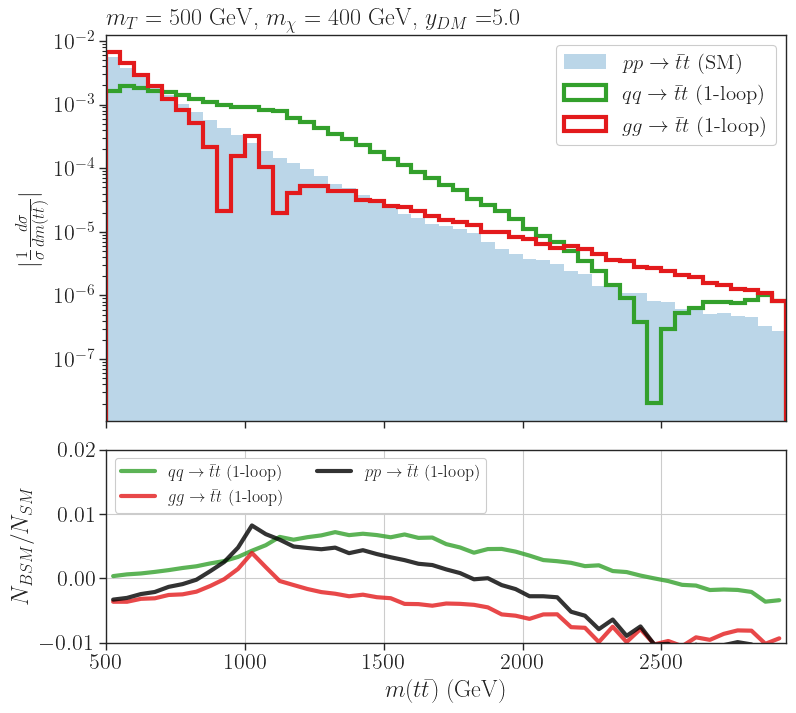

In [9]:
# Define scale factor (new yDM value)
kscales = {f : 1.0 for f in smFiles}
yDM = 5.0
kscales.update({f : 1.0*(yDM/fileData[f]['(mST,mChi,mT,yDM)'][-1])**2 for f in bsmFiles})

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
bins = np.arange(500.,3000.,50.)

labels = []
pmodels = []
hists = []
histsErr = []
c = []
ks = []
for f in dists:
    process = fileData[f]['process']
    model = fileData[f]['model']
    mST,mChi,mT,_ = fileData[f]['(mST,mChi,mT,yDM)']
    
    kscale = kscales[f]
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels.append(label)
    c.append(colors[f])
    ks.append(kscale)
    h,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=kscale*dists[f]['weights'])
    hists.append(h)
    #Compute MC error
    hErr,_ = np.histogram(dists[f]['mTT'],bins=bins,weights=(kscale*dists[f]['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr.append(hErr)
    

histsSM = [h for i,h in enumerate(hists) if 'SM' in labels[i]]    
histsErrSM = [h for i,h in enumerate(histsErr) if 'SM' in labels[i]]
labelsSM = [l for i,l in enumerate(labels) if 'SM' in labels[i]]    
cSM =  [cc for i,cc in enumerate(c) if 'SM' in labels[i]]    
axarr[0].hist([bins[:-1]]*len(histsSM),label=labelsSM,bins=bins,
                          weights=histsSM,alpha=0.3,density=True,
                          linewidth=0,color=cSM,stacked=True)

hSM = sum([hh for hh in histsSM[:]])
hErrSM = np.sqrt(sum([hh**2 for hh in histsErrSM[:]]))
labelsTrack = []
for i,h in enumerate(hists):
    if 'SM' in labels[i]:
        continue    
    axarr[0].hist(bins[:-1],weights=np.abs(h),label=labels[i],bins=bins,
                  color=c[i],alpha=1.0,histtype='step',density=True,
                  linewidth=3,fill=False,zorder=i,linestyle='solid')

# Ratio plot:
hLoop = sum([h for i,h in enumerate(hists) if '1-loop' in labels[i]])
labels.append(r'$p p \to \bar{t} t$ (1-loop)')
c.append('black')
c.append('gray')
for i,h in enumerate(hists+[hLoop]):
    if 'SM' in labels[i]:
        continue
    if (not 'loop' in labels[i]) and (not 'p p ' in labels[i]):
        continue
    # Compute ratio (keeping negative and positive values)
    ratio = np.divide(h, hSM, out=np.zeros_like(h),where=hSM != 0)
    # Remove zero values
    nonzero = np.where((np.sign(ratio) != 0))
    x = (bins[:-1]+bins[1:])/2.0
    y = ratio
    label = labels[i]
    axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=0.8,
                          label=label,c=c[i])
        
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-4,500)
# axarr[0].set_xticks(np.arange(0.,bins.max(),500))
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[1].set_ylabel(r'$N_{BSM}/N_{SM}$')
axarr[1].set_ylim(-0.01,0.02)
axarr[1].set_yticks(np.arange(-0.01,0.03,0.01))
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].grid()


axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
# axarr[1].legend(framealpha=1.0,loc='upper left')
axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mST,mChi,yDM),
                   loc='left')
plt.savefig('mtt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()

### Check invariant mass bins

In [10]:
CMS_mtt_bins = [300.0,375.0,450.,530.,625.,740.,850.,1100.,2000.]
yDM = 1.0
for f in dists:
    w = np.array(dists[f]['weights'])
    w = w*(yDM/fileData[f]['(mST,mChi,mT,yDM)'][-1])**2
    h,b = np.histogram(dists[f]['mTT'],bins=CMS_mtt_bins,weights=w)
    print(f)
    for x,y in zip(b,h):
        print(f'  mtt_min = {x}, w = {y:1.4e} pb')

../../pp2ttbar-loop_SM/Events/run_01/events.lhe.gz
  mtt_min = 300.0, w = 2.0054e+00 pb
  mtt_min = 375.0, w = 6.5368e+00 pb
  mtt_min = 450.0, w = 4.9027e+00 pb
  mtt_min = 530.0, w = 3.2246e+00 pb
  mtt_min = 625.0, w = 1.9214e+00 pb
  mtt_min = 740.0, w = 8.8185e-01 pb
  mtt_min = 850.0, w = 7.6079e-01 pb
  mtt_min = 1100.0, w = 3.1858e-01 pb
../../qq2ttbar-loop_scan/Events/run_01/events.lhe.gz
  mtt_min = 300.0, w = 3.2354e-05 pb
  mtt_min = 375.0, w = 9.7464e-04 pb
  mtt_min = 450.0, w = 1.3576e-03 pb
  mtt_min = 530.0, w = 1.8670e-03 pb
  mtt_min = 625.0, w = 1.8847e-03 pb
  mtt_min = 740.0, w = 1.4580e-03 pb
  mtt_min = 850.0, w = 2.4062e-03 pb
  mtt_min = 1100.0, w = 2.0280e-03 pb
../../gg2ttbar-loop_scan/Events/run_01/events.lhe.gz
  mtt_min = 300.0, w = -1.0805e-02 pb
  mtt_min = 375.0, w = -2.9584e-02 pb
  mtt_min = 450.0, w = -1.9637e-02 pb
  mtt_min = 530.0, w = -1.1257e-02 pb
  mtt_min = 625.0, w = -5.8189e-03 pb
  mtt_min = 740.0, w = -2.0651e-03 pb
  mtt_min = 850.0, w 